# 

# TODO
- reinstall transformers with pytorch-nightly so that can use `mps` device

# Few to No Labels
Concepts Covered:
* Multi-label classification
* Baseline: Naive Bayes cast as a one-vs-rest problem (using `scikit-multilearn`)
* zero-shot classfication: recasting problem as a text entailment problem. 
    * top k vs threshold approach
* Text data augmentation (`nlpaug` library) 
* Using embeddings as a lookup table (FAISS)
    * how many neighbors? what threshold?
* Fine-Tuning a Vanilla Transformer
* Domain Adaptation: Fine-Tuning language model on unlabeled data before training model on labeled data.


**Original Application**: Github issue tagging  
**Proposed Application**: NEoD conversation tagging

## Dataset Preparation




In [9]:
from src.n_nine import plot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
 import pandas as pd

 DATASET_URL = "https://git.io/nlp-with-transformers"
 df_issues = pd.read_json(DATASET_URL, lines=True)

 print(f"Dataframe shape: {df_issues.shape}")

# only keep label name (drop id, nodes, ...)
 df_issues["labels"] = df_issues.labels.apply(lambda l: [n['name'] for n in l])

# keep main labels and map to simpler lower case labels
 label_map = {
    "Core: Tokenization": "tokenization",
    "New model": "new model",
    "Core: Modeling": "model training",
    "Usage": "usage",
    "Core: Pipeline": "pipeline",
    "TensorFlow": "tensorflow",
    "PyTorch": "pytorch",
    "Examples": "examples",
    "Documentation": "documentation"
}

def filter_labels(labels: list[str]) -> list[str]:
    return [label_map[label] for label in labels if label in label_map]

df_issues["labels"] = df_issues.labels.apply(filter_labels)
all_labels = list(label_map.values())

# adding a flag to know whether issue has at least one labeled or not
df_issues["labeled"] = df_issues.labels.apply(len) > 0


# drop duplicates
df_issues["text"] = df_issues.title + "\n\n" + df_issues.body
previous_length = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")

print(f"duplicates dropped: {previous_length - len(df_issues)}")

Dataframe shape: (9930, 26)
duplicates dropped: 187


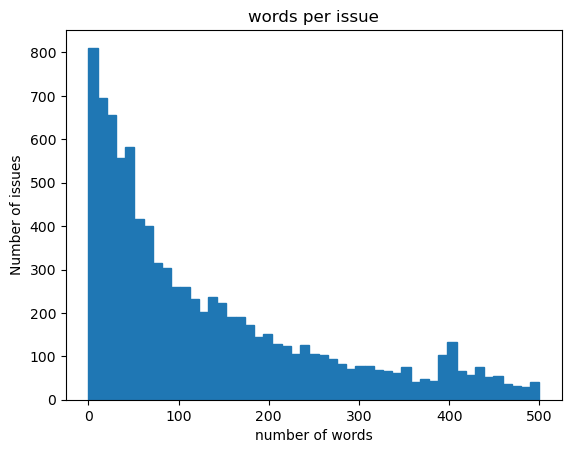

In [11]:
import numpy as np
import matplotlib.pyplot as plt

(
    df_issues["text"].str.split()
    .apply(len)
    .hist(bins=np.linspace(0,500,50), grid=False, edgecolor="C0")
)
plt.title("words per issue")
plt.xlabel("number of words")
plt.ylabel("Number of issues")
plt.show()


# Creating a Training Set

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

# fit a label binarizer on data
mlb = MultiLabelBinarizer()

mlb.fit([all_labels])
print(mlb.transform([["tokenization", "pytorch"], ["tensorflow"]]))

# 
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df: pd.DataFrame, test_size: float= 0.5) -> tuple[pd.DataFrame]:
    idx = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    idx_train, _, idx_test, _ = iterative_train_test_split(idx, labels, test_size=test_size)

    return df.iloc[idx_train[:,0]], df.iloc[idx_test[:,0]]

df_clean = df_issues[["text", "labels", "labeled"]].reset_index(drop=True).copy()

df_unsup = df_clean.loc[~df_clean.labeled, ["text","labels"]]
df_sup = df_clean.loc[df_clean.labeled, ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)


[[0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 1 0 0]]


In [13]:
import datasets
ds = datasets.DatasetDict({
    "train": datasets.Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": datasets.Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": datasets.Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": datasets.Dataset.from_pandas(df_unsup.reset_index(drop=True)),
})

ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['text', 'labels'],
        num_rows: 9303
    })
})

### Creating Training Slices
Goal: test how efficient different strategies are depending on number of labeled samples

In [14]:
np.random.seed(0)
# create list of all indices
all_indices = np.expand_dims(np.arange(len(ds["train"])), axis=1)

# indices_pool = array with indices available to pool from 
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [2**x for x in range(3,8)]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    indices_pool, labels, new_slice, _ = iterative_train_test_split(indices_pool, labels, (k-last_k) / len(labels))
    
    last_k = k 
    if i == 0: 
        train_slices.append(new_slice)
    else:
        train_slices.append(np.concatenate([train_slices[-1], new_slice]))

# add full dataset as last slice:
train_slices.append(all_indices) 
train_samples.append(len(ds["train"]))


train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

print(f"target split size: {train_samples}")
print(f"actual split size: {[len(s) for s in train_slices]}")

target split size: [8, 16, 32, 64, 128, 223]
actual split size: [10, 19, 36, 68, 134, 223]


In [15]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

## Create Metrics Record

In [16]:
from collections import defaultdict

f1_scores = {"micro": defaultdict(list), "macro": defaultdict(list)}

# Naive Bayes Baseline

In [17]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report



def evaluate_pipe_on_slices(pipe: Pipeline, strategy: str, f1_scores: dict) -> None:
    for train_slice in train_slices:
        ds_train_sample = ds["train"].select(train_slice)
        y_train = np.array(ds_train_sample["label_ids"])
        y_test = np.array(ds["test"]["label_ids"])

        # fit pipeline
        _ = pipe.fit(ds_train_sample["text"], y_train)

        # generate preds and evaluate
        y_pred_test = pipe.predict(ds["test"]["text"])
        clf_report = classification_report(y_test, y_pred_test, 
            target_names=mlb.classes_, 
            zero_division=0, 
            output_dict=True)

        f1_scores["macro"][strategy].append(clf_report["macro avg"]["f1-score"])
        f1_scores["micro"][strategy].append(clf_report["micro avg"]["f1-score"])

    return f1_scores


pipe = Pipeline([("vectorizer", CountVectorizer()), ("clf", BinaryRelevance(classifier=MultinomialNB()))])

f1_scores = evaluate_pipe_on_slices(pipe, strategy="Naive Bayes", f1_scores=f1_scores)



In [18]:
pipe = Pipeline([("vectorizer", TfidfVectorizer()), ("clf", BinaryRelevance(classifier=MultinomialNB()))])

f1_scores = evaluate_pipe_on_slices(pipe, strategy="Naive Bayes tfidf", f1_scores=f1_scores)


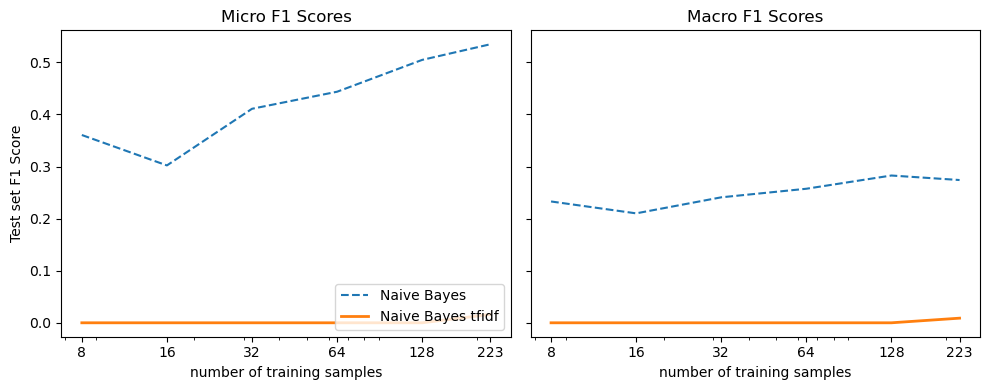

In [21]:
plot.plot_metrics(f1_scores, train_samples, "Naive Bayes tfidf")

## Working with No Labeled Data: Zero-Shot Classification
* turn task into an entailment task to figure out whether topics are related by comparing text to a sentence of the form: `"this section was about the topic [MASK]"`